<a href="https://colab.research.google.com/github/LeonardoSanBenitez/Unlearn-Saliency/blob/master/PEM_composition_img_gen/01_train_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import os

is_colab: bool = 'google.colab' in sys.modules

if is_colab:
    # You need to manually create the .env file
    %cd /content
    !pip install python-dotenv
    import dotenv
    dotenv.load_dotenv()

    import os
    assert (os.getenv("HF_TOKEN") is not None) and (len(os.getenv("HF_TOKEN"))>0)

    # TODO: install the dependencies from our repo, not from difusers
    if not os.path.exists('diffusers'):
        !git clone https://github.com/huggingface/diffusers
    %cd diffusers
    !pip install .
    !pip install torchmetrics

    %cd examples/text_to_image
    !pip install -r requirements.txt

    !huggingface-cli login --token ${HF_TOKEN}
    !accelerate config default

    %cd /content/
    if not os.path.exists('Unlearn-Saliency'):
        !git clone https://github.com/LeonardoSanBenitez/Unlearn-Saliency.git
    %cd /content/Unlearn-Saliency/PEM_composition_img_gen
elif "alumnos" in os.getcwd():
    %cd ~
    if not os.path.exists('Unlearn-Saliency'):
        !git clone https://github.com/LeonardoSanBenitez/Unlearn-Saliency.git
    %cd ~/Unlearn-Saliency/PEM_composition_img_gen

    !python3.10 -m pip install poetry~=1.2
    !python3.10 -m poetry config virtualenvs.create true

    if os.path.exists("poetry.lock"):
        !rm poetry.lock
    !sed -i 's/python = "~3.11"/python = "~3.10"/' ./pyproject.toml
    !python3.10 -m poetry install --no-root --no-interaction --no-ansi
    
    import dotenv
    dotenv.load_dotenv()
    assert (os.getenv("HF_TOKEN") is not None) and (len(os.getenv("HF_TOKEN"))>0)

    !huggingface-cli login --token ${HF_TOKEN}
    !accelerate config default

/home/alumnos/e536095
/home/alumnos/e536095/Unlearn-Saliency/PEM_composition_img_gen
  Using cached poetry-1.8.5-py3-none-any.whl.metadata (6.9 kB)
  Using cached build-1.2.2.post1-py3-none-any.whl.metadata (6.5 kB)
  Using cached cachecontrol-0.14.2-py3-none-any.whl.metadata (3.1 kB)
  Using cached cleo-2.1.0-py3-none-any.whl.metadata (12 kB)
  Using cached crashtest-0.4.1-py3-none-any.whl.metadata (1.1 kB)
  Using cached dulwich-0.21.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.3 kB)
  Using cached installer-0.7.0-py3-none-any.whl.metadata (936 bytes)
  Using cached keyring-24.3.1-py3-none-any.whl.metadata (20 kB)
  Using cached pkginfo-1.12.1.2-py3-none-any.whl.metadata (13 kB)
  Using cached poetry_core-1.9.1-py3-none-any.whl.metadata (3.5 kB)
  Using cached poetry_plugin_export-1.9.0-py3-none-any.whl.metadata (3.1 kB)
  Using cached pyproject_hooks-1.2.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl.metad

In [ ]:
dataset_forget_name = "lambdalabs/naruto-blip-captions"  # https://huggingface.co/datasets/lambdalabs/naruto-blip-captions
dataset_retain_name = "Hamdy20002/COCO_Person"  # https://huggingface.co/datasets/Hamdy20002/COCO_Person
model_name = "stable-diffusion-v1-5/stable-diffusion-v1-5"
output_dir = "./assets/lora/naruto"  # Local output
hub_model_id = "LeonardoBenitez/sd-lora-naruto"  # Remote output, https://huggingface.co/LeonardoBenitez/sd-lora-naruto

In [64]:
import datasets
from PIL import Image
import matplotlib.pyplot as plt
import random
from diffusers import AutoPipelineForText2Image, StableDiffusionPipeline
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchmetrics.functional.multimodal import clip_score
from functools import partial
from typing import Literal, List, Dict, Tuple, Optional, Callable, Union

ModuleNotFoundError: No module named 'datasets'

Repo card metadata block was not found. Setting CardData to empty.


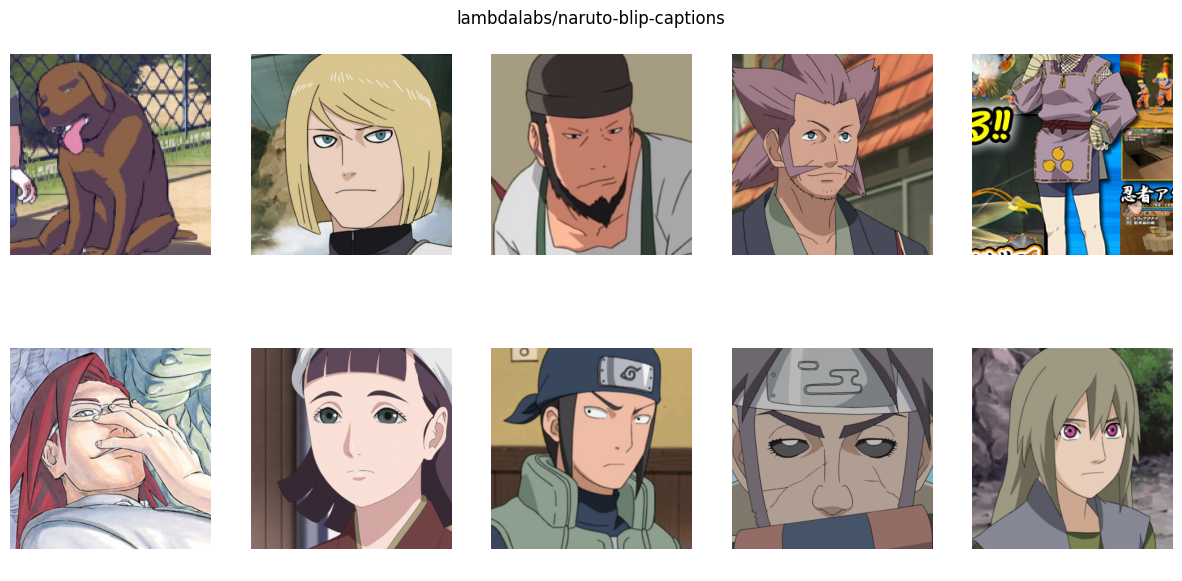

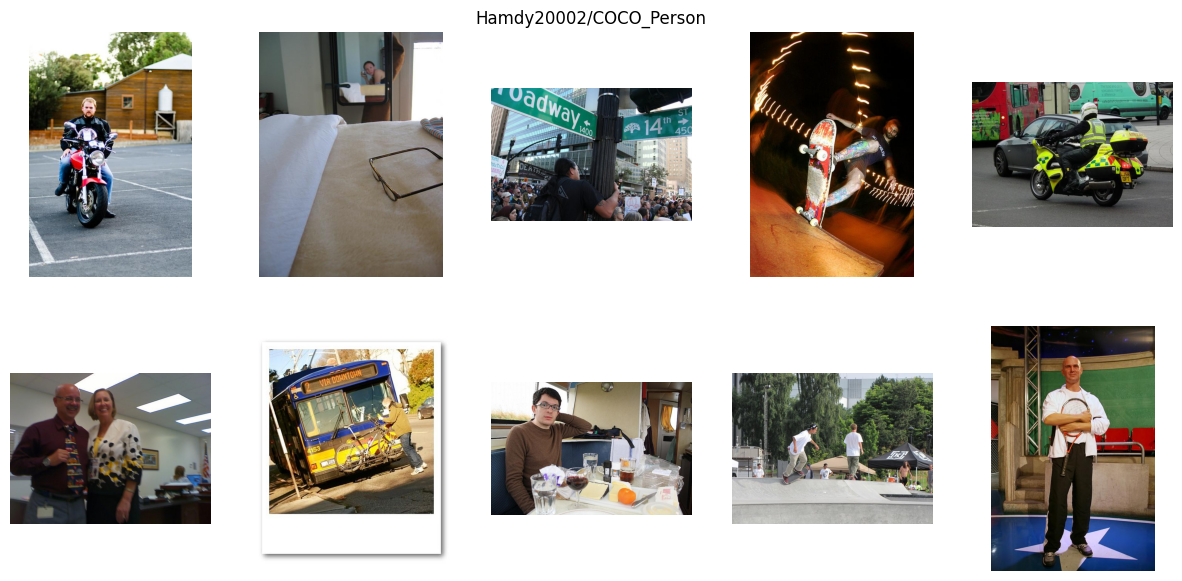

In [10]:
def hf_dataset_display_random_images(dateset_name: str, num_images: int = 10, split: str = "train", title: Optional[str] = None):
    dataset = datasets.load_dataset(dateset_name, split=split)
    random_indices = random.sample(range(len(dataset)), num_images)
    selected_images = [dataset[i]["image"] for i in random_indices]
    plt.figure(figsize=(15, 7))
    if title:
        plt.title(title)
        plt.axis('off')
    assert num_images <= 10, "num_images must be <= 10"
    for i, image in enumerate(selected_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(image)
        plt.axis('off')

hf_dataset_display_random_images(dataset_forget_name, title=dataset_forget_name)
hf_dataset_display_random_images(dataset_retain_name, title=dataset_retain_name)

# Train

In [56]:
!accelerate launch --mixed_precision="fp16"  train_text_to_image_lora_munba.py \
    --pretrained_model_name_or_path={model_name} \
    --dataset_forget_name={dataset_forget_name} \
    --dataset_retain_name={dataset_retain_name} \
    --dataloader_num_workers=8 \
    --resolution=512 \
    --center_crop \
    --random_flip \
    --mixed_precision "fp16" \
    --train_batch_size=2 \
    --gradient_accumulation_steps=4 \
    --learning_rate=2e-04 \
    --max_grad_norm=1 \
    --lr_scheduler="cosine" \
    --lr_warmup_steps=0 \
    --output_dir={output_dir} \
    --push_to_hub \
    --hub_model_id={hub_model_id} \
    --num_train_epochs=1 \
    --validation_epochs=3 \
    --checkpointing_steps=500 \
    --validation_prompt="A naruto with blue eyes." \
    --seed=42

02/25/2025 19:14:15 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

{'variance_type', 'clip_sample_range', 'prediction_type', 'thresholding', 'sample_max_value', 'timestep_spacing', 'dynamic_thresholding_ratio', 'rescale_betas_zero_snr'} was not found in config. Values will be initialized to default values.
{'scaling_factor', 'latents_mean', 'use_post_quant_conv', 'force_upcast', 'shift_factor', 'use_quant_conv', 'mid_block_add_attention', 'latents_std'} was not found in config. Values will be initialized to default values.
{'resnet_time_scale_shift', 'addition_time_embed_dim', 'num_attention_heads', 'addition_embed_type', 'time_embedding_act_fn', 'addition_embed_type_num_heads', 'only_cross_attention', 'encoder_hid_dim', 'projection_class_embeddings_input_dim', 'resnet_skip_time_act', 'encoder_hid_dim_type', 'mid_block_type', 'time_embedding_dim', 'conv_in_kernel', 'dual_cross_attention'

# Evaluation and scoring

In [ ]:
# TODO

# Interactive testing

In [62]:
class ImageTextSimilarityJudge:
    metrics: List[Literal['clip']]
    _clip_score_fn: Optional[Callable]

    def __init__(self, metrics: List[Literal['clip']]):
        self.metrics = metrics

        # Download the models for the LPIPS metrics, if required
        if 'clip' in self.metrics:
            self._clip_score_fn = partial(clip_score, model_name_or_path="openai/clip-vit-base-patch16")

    def evaluate(self, image: Union[Image.Image, np.ndarray], text: str) -> Dict[str, float]:
        scores: Dict[str, float] = {}

        # Preprocess
        image_np: np.ndarray
        if isinstance(image, Image.Image):
            image_np = np.array(image)
        else:
            image_np = image
        image_int = (image_np * 255).astype("uint8")

        # Calculate
        for metric in self.metrics:
            if metric == 'clip':
                assert self._clip_score_fn is not None
                scores[metric] = float(self._clip_score_fn(torch.from_numpy(image_int), text).detach())
        return scores


def eval_text_to_image_unlearning(
    pipeline_original: StableDiffusionPipeline,
    pipeline_learned: StableDiffusionPipeline,
    pipeline_unlearned: StableDiffusionPipeline,
    prompts: List[str],
    judge_clip: ImageTextSimilarityJudge,
) -> Tuple[List[float], List[float], List[float]]:
    scores_original: List[float] = []
    scores_learned: List[float] = []
    scores_unlearned: List[float] = []
    for prompt in prompts:
        image_original = pipeline_original(prompt).images[0]
        image_learned = pipeline_learned(prompt).images[0]
        image_unlearned = pipeline_unlearned(prompt).images[0]

        score_original = judge_clip.evaluate(image_original, prompt)['clip']
        score_learned = judge_clip.evaluate(image_learned, prompt)['clip']
        score_unlearned = judge_clip.evaluate(image_unlearned, prompt)['clip']
        scores_original.append(score_original)
        scores_learned.append(score_learned)
        scores_unlearned.append(score_unlearned)

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(image_original)
        axes[0].set_title(f"Original\nClip Score={score_original:.2f}")
        axes[0].axis("off")
        axes[1].imshow(image_learned)
        axes[1].set_title(f"Learned\nClip Score={score_learned:.2f}")
        axes[1].axis("off")
        axes[2].imshow(image_unlearned)
        axes[2].set_title(f"Unlearned\nClip Score={score_unlearned:.2f}")
        axes[2].axis("off")
        fig.suptitle(prompt, fontsize=16)
        plt.show()

    print(f"Original score: {np.mean(scores_original)} +- {np.std(scores_original)}")
    print(f"Learned score: {np.mean(scores_learned)} +- {np.std(scores_learned)}")
    print(f"Unlearned score: {np.mean(scores_unlearned)} +- {np.std(scores_unlearned)}")
    print(f"Difference between learned and unlearned: {np.mean(scores_learned) - np.mean(scores_unlearned)}")
    return scores_original, scores_learned, scores_unlearned

NameError: name 'List' is not defined

In [ ]:
pipeline_original = AutoPipelineForText2Image.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", torch_dtype=torch.float16, safety_checker=None).to("cuda")

pipeline_learned = AutoPipelineForText2Image.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", torch_dtype=torch.float16, safety_checker=None).to("cuda")
pipeline_learned.load_lora_weights(hub_model_id, weight_name="pytorch_lora_weights.safetensors")

pipeline_unlearned = AutoPipelineForText2Image.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", torch_dtype=torch.float16, safety_checker=None).to("cuda")
pipeline_unlearned.load_lora_weights(hub_model_id, weight_name="pytorch_lora_weights.safetensors")
total: int = 0
sum_before_invert: float = sum([float(param.sum()) for name, param in pipeline_unlearned.unet.named_parameters() if "lora_A" in name])
for name, param in pipeline_unlearned.unet.named_parameters():
    if "lora_A" in name:
        print(f"Inverting param {name}")
        param.data = -1 * param.data
        total += 1
assert sum_before_invert == -sum([float(param.sum()) for name, param in pipeline_unlearned.unet.named_parameters() if "lora_A" in name])
assert total > 0
print(f"Inverted {total} params")

judge = ImageTextSimilarityJudge(metrics=['clip'])

In [ ]:
# Forget prompts
# These are prompts we DO NOT want to be able to generate well
# So CLIP score should be low (prompt and image are semantically different) for the unlearned model
# The difference between learned and unlearned model should be high (negating changed the generation) and positive (learned is better than unlearned)
prompts = [
    "A naruto with blue eyes",
    "One naruto character with dark hair and brown eyes",
    "Naruto in a blue shirt and headband",
    "Naruto with a white hat and a red cross on his head",
    "Naruto in armor standing in front of a blue background",
    "A character from the anime naruto with yellow air and orange clothing, hand drawn",
    "A woman from the anime naruto, wearing clothing from the anime, standing in front of a traditional building",
    "An anime character in a white suit with a purple face, drawn in naruto-style",
    "Naruto",
    "Many characters from the series Naruto laughing and hugging each other as a family",
]
#prompts = prompts[:1] # Select one, to speed up
_ = eval_text_to_image_unlearning(pipeline_original, pipeline_learned, pipeline_unlearned, prompts, judge)

In [ ]:
# Retain prompts
# These are prompts we want to be able to generate well
# So CLIP score should be high (prompt and image are semantically similar) for the unlearned model
# The difference between learned and unlearned model should be small (both generate about the same, there is no forgetting) and negative (unlearned is closer to how it should be)
prompts = [
    "A man with blue eyes",
    "One person with dark hair and brown eyes",
    "A man in a blue shirt and headband",
    "A man with a white hat and a red cross on his head",
    "A man in armor standing in front of a blue background",
    "A character with yellow air and orange clothing, hand drawn",
    "A woman in a suit and tie standing in front of a building",
    "An cartoon character in a white suit with a purple face",
    "A cartoon character",
    "Many people from the series Naruto laughing and hugging each other as a family",
]
#prompts = prompts[:1] # Select one, to speed up
_ = eval_text_to_image_unlearning(pipeline_original, pipeline_learned, pipeline_unlearned, prompts, judge)